In [29]:
import yfinance as yf              # Used for gathering stock prices
import matplotlib.pyplot as plt    # Used for Data Visualization / Plots / Graphs
import pandas as pd                # Helpful for working with tabular data like DataFrames
import os                          # Interacting with the operating system

from langchain.text_splitter import RecursiveCharacterTextSplitter      #  Helpful in splitting the PDF into smaller chunks

from langchain_community.document_loaders import PyPDFDirectoryLoader, PyPDFLoader     # Loading a PDF
from langchain_community.vectorstores import Chroma    # Vector DataBase

In [30]:
companies = ["GOOGL", "MSFT", "IBM", "NVDA", "AMZN"]

Setting up LLM

In [31]:
#Loading the `config.json` file
import json
import os

# Load the JSON file and extract values
file_name = "config.json"
with open(file_name, 'r') as file:
    config = json.load(file)
    os.environ['OPENAI_API_KEY'] = config["API_KEY"] # Loading the API Key
    os.environ["OPENAI_BASE_URL"] = config["OPENAI_API_BASE"] # Loading the API Base Url
from langchain_openai import ChatOpenAI
llm = ChatOpenAI(
    model="gpt-4o-mini",                      # "gpt-4o-mini" to be used as an LLM
    temperature=0,                # Set the temprature to 0
    max_tokens=5000,                 # Set the max_tokens = 5000, so that the long response will not be clipped off
    top_p=0.95,
    frequency_penalty=1.2,
    stop_sequences=['INST'])

In [32]:
import pandas as pd
import matplotlib.pyplot as plt

companies = ["GOOGL", "MSFT", "IBM", "NVDA", "AMZN"]
metrics_list = {}

# Fetching the financial metrics
for symbol in companies:                          # Loop through all the companies
    ticker = yf.Ticker(symbol)
    info = ticker.info
    metrics_list[symbol] = {                              # Define the dictionary of all the Finanical Metrics
        "Market Cap": info.get("marketCap", 0),
        "P/E Ratio": info.get("trailingPE", 0),
        "Dividend Yield": info.get("dividendYield", 0),
        "Beta": info.get("beta", 0),
        "Total Revenue": info.get("totalRevenue", 0)
    }

In [33]:
# Convert to DataFrame
df = pd.DataFrame(metrics_list).T

# Converting large numbers to billions for readability by divinding the whole column by 1e9
df["Market Cap"] = df["Market Cap"] / 1e9
df["Total Revenue"] = df["Total Revenue"] / 1e9
df["Dividend Yield"] = df["Dividend Yield"] * 100  # Convert to percentage

df   # Printing the df

,Market Cap,P/E Ratio,Dividend Yield,Beta,Total Revenue
GOOGL,3899.861238,31.816208,27.0,1.086,385.476002
MSFT,3593.712959,34.361763,76.0,1.073,293.812011
IBM,277.363982,35.409310,222.0,0.698,65.401999
NVDA,4604.261564,46.809406,2.0,2.314,187.141997
AMZN,2582.328639,34.118645,0.0,1.376,691.330023


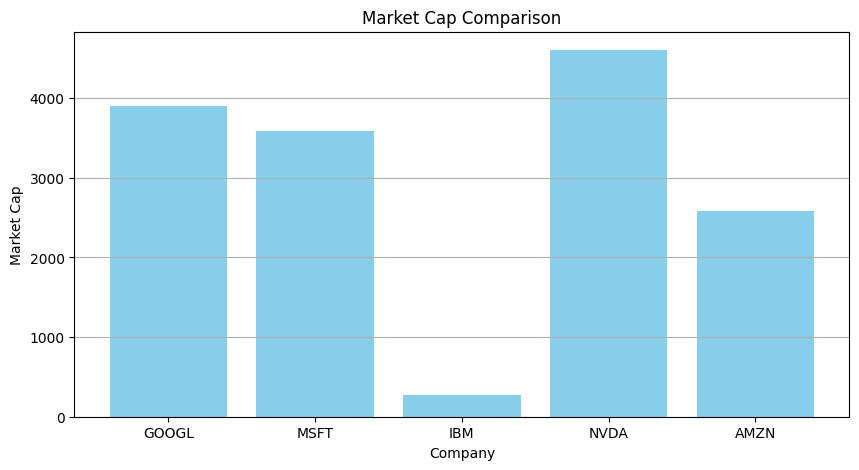

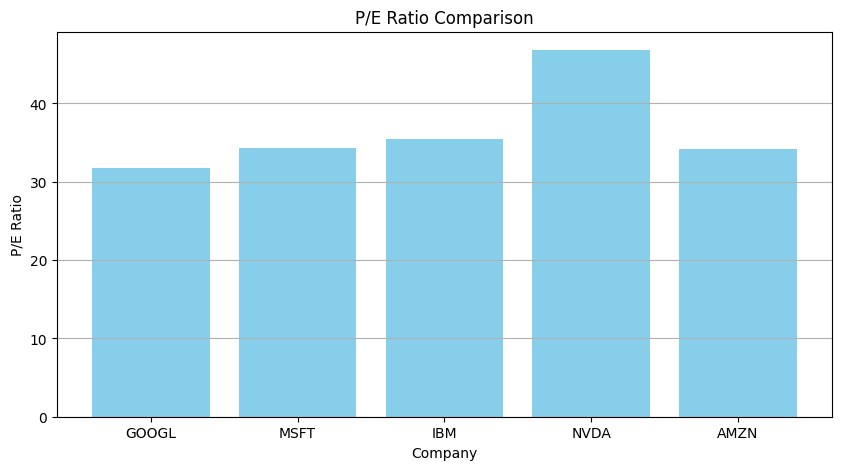

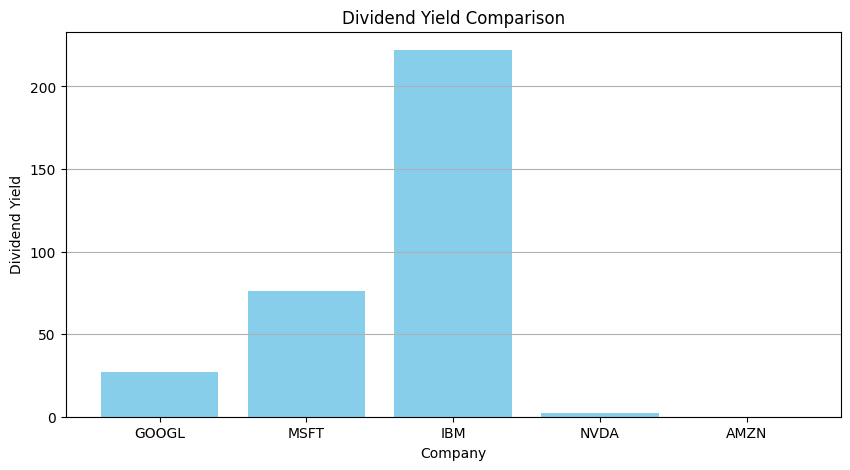

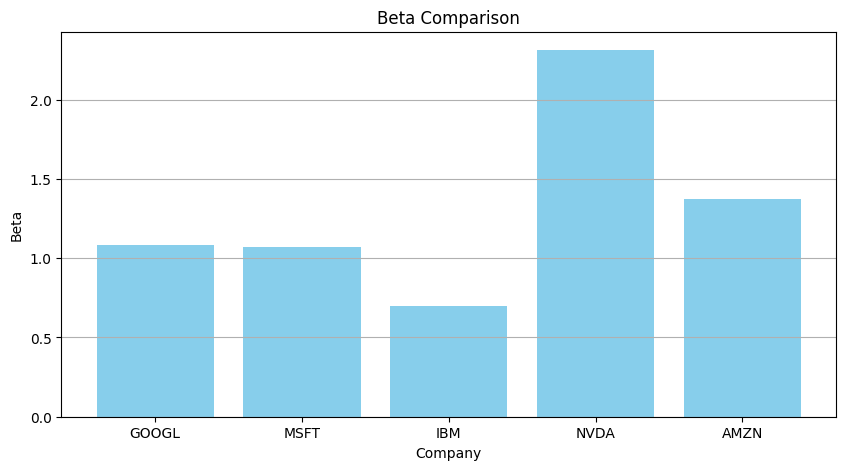

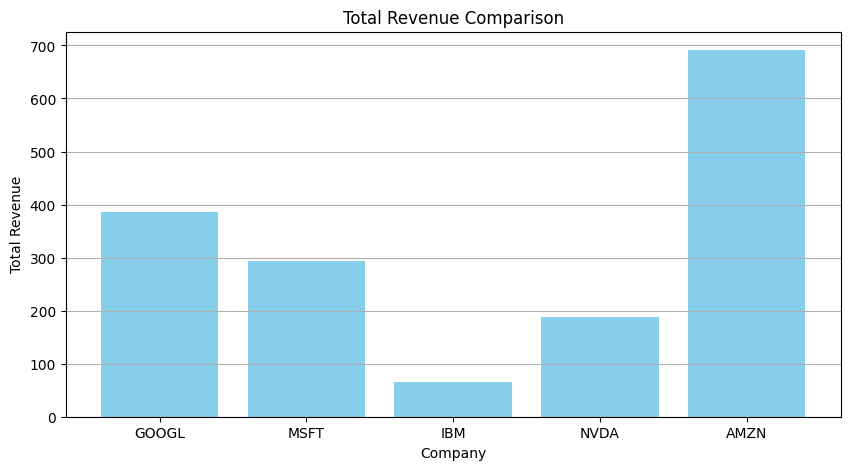

In [34]:
# Plot each metric as a separate bar graph
metrics_to_plot = ["Market Cap", "P/E Ratio", "Dividend Yield", "Beta", "Total Revenue"]

for metric in metrics_to_plot:
    plt.figure(figsize=(10,5))
    plt.bar(df.index, df[metric], color='skyblue')
    plt.title(f"{metric} Comparison")
    plt.ylabel(metric)
    plt.xlabel("Company")
    plt.grid(axis='y')
    plt.show()

Visualization and Insight Extraction

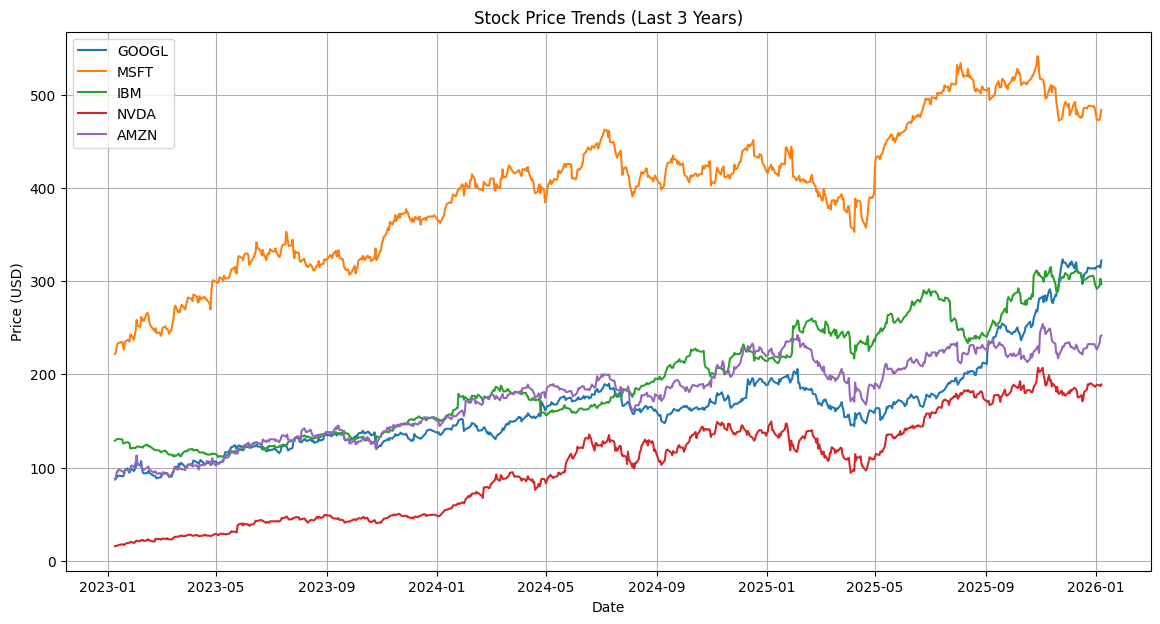

In [35]:
plt.figure(figsize=(14,7))

# Loop through each company and plot closing prices
for symbol in companies:
    ticker = yf.Ticker(symbol)
    data = ticker.history(period="3y")

    # Plot closing price
    plt.plot(data.index, data['Close'], label=symbol)

plt.title("Stock Price Trends (Last 3 Years)")
plt.xlabel("Date")
plt.ylabel("Price (USD)")
plt.legend()
plt.grid(True)
plt.savefig("Stock_Price_Trends_3Y.png")
plt.show()

Loading Company AI Documents Pack

In [36]:
import zipfile
import os

zip_path = "/Users/anshimittal/Downloads/Companies-AI-Initiatives.zip"
extract_path = "/Users/anshimittal/Downloads/Companies-AI-Initiatives/data/raw_pdfs"

os.makedirs(extract_path, exist_ok=True)

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

base_dir = "/Users/anshimittal/Downloads/Companies-AI-Initiatives"

ai_initiative_pdf_paths = [
    os.path.join(base_dir, file)
    for file in os.listdir(base_dir)
    if file.endswith(".pdf")
]

In [37]:
from langchain_community.document_loaders import PyPDFDirectoryLoader
from langchain.text_splitter import RecursiveCharacterTextSplitter

loader = PyPDFDirectoryLoader(path = "/Users/anshimittal/Downloads/Companies-AI-Initiatives/data/raw_pdfs")

# Defining the text splitter
text_splitter = RecursiveCharacterTextSplitter.from_tiktoken_encoder(
    encoding_name='cl100k_base',
    chunk_size=1024,
    chunk_overlap=256
)

# Splitting the chunks using the text splitter
ai_initiative_chunks = loader.load_and_split(text_splitter)
# Total length of all the chunks
len(ai_initiative_chunks)

60

Vectorizing AI Initiative Documents

In [38]:
# Defining the 'text-embedding-ada-002' as the embedding model
from langchain_openai import OpenAIEmbeddings
from langchain_community.vectorstores import Chroma

embedding_model = OpenAIEmbeddings(model="text-embedding-ada-002")
#  Creating a Vectorstore, storing all the above created chunks using an embedding model
vectorstore = Chroma.from_documents(
    ai_initiative_chunks,
    embedding_model,
    collection_name="AI_Initiatives"
)

# Ignore if it gives an error or warning
# Creating an retriever object which can fetch ten similar results from the vectorstore
retriever = vectorstore.as_retriever(
    search_type="similarity",
    search_kwargs={"k": 10}
)

Retrieving relevant Documents

In [39]:
user_message = "Give me the best project that `IBM` company is working upon"
# Building the context for the query using the retrieved chunks
relevant_document_chunks = retriever.get_relevant_documents(user_message)
context_list = [d.page_content for d in relevant_document_chunks]
context_for_query = ". ".join(context_list)
len(relevant_document_chunks)
# Write a system message for an LLM to help craft a response from the provided context
qna_system_message = """

You are a careful analyst answering questions ONLY using the provided Context.

Rules:
- Use ONLY the Context to answer. If the Context does not contain enough information to answer, say: 
  "I don't have enough information in the provided documents to answer that."
- Do NOT use outside knowledge. Do NOT guess.
- Be specific and concise: 5–10 sentences.
- If multiple IBM projects are mentioned, rank the top 1–3 by (a) impact described, (b) specificity/detail in context, and (c) recency if stated.
- Always include citations for claims using the source metadata when available:
  Format each citation like: [source: <source>, page: <page>] or [source: <source>]
- End with a short bullet list titled "Evidence" listing 2–5 quoted short phrases (max 12 words each) from the Context that support your answer.

"""

# Write an user message template which can be used to attach the context and the questions
qna_user_message_template = """
###Context
Here are some documents that are relevant to the question mentioned below.
{context}

###Question
{question}
"""

In [40]:
# Format the prompt
formatted_prompt = f"""[INST]{qna_system_message}\n
                {'user'}: {qna_user_message_template.format(context=context_for_query,
    question=user_message)}
                [/INST]"""

In [41]:
# Define RAG function
def RAG(user_message):
    """
    Args:
    user_message: Takes a user input for which the response should be retrieved from the vectorDB.
    Returns:
    relevant context as per user query.
    """
    relevant_document_chunks = retriever.get_relevant_documents(user_message)
    context_list = [d.page_content for d in relevant_document_chunks]
    context_for_query = ". ".join(context_list)



    # Combine qna_system_message and qna_user_message_template to create the prompt
    prompt = f"""[INST]{qna_system_message}\n
                {'user'}: {qna_user_message_template.format(context=context_for_query, question=user_message)}
                [/INST]"""

    # Quering the LLM
    try:
        response = llm.invoke(prompt)

    except Exception as e:
        response = f'Sorry, I encountered the following error: \n {e}'

    return response.content
# Test Cases
print(RAG("How is the area in which GOOGL is working different from the area in which MSFT is working?"))
print(RAG("What are the three projects on which MSFT is working upon?"))
print(RAG("What is the timeline of each project in NVDA?"))
print(RAG("What are the areas in which AMZN is investing when it comes to AI?"))
print(RAG("What are the risks associated with projects within GOOG?"))

Google (GOOGL) and Microsoft (MSFT) are both heavily invested in artificial intelligence, but they focus on different aspects and applications of AI. Google emphasizes the development of advanced AI models like Gemini, which integrates multimodal capabilities across text, images, and code to enhance reasoning and generative tasks within its consumer products such as Google Search and Workspace [source: <source>]. This initiative aims to improve user experience through automation and real-time decision-making while maintaining a strong emphasis on responsible AI development.

In contrast, Microsoft's approach centers around integrating AI into productivity tools through initiatives like Azure AI Foundry Labs and GitHub Copilot. These platforms aim to streamline workflows in enterprise applications such as Microsoft 365 by enhancing productivity with natural language processing, machine learning, computer vision, and generative AI [source: <source>]. While both companies prioritize ethic

Evaluation of Rag

In [42]:
# Writing a question for performing evaluations on the RAG
evaluation_test_question = "What are the three projects on which MSFT is working upon?"
# Building the context for the evaluation test question using the retrieved chunks
relevant_document_chunks = retriever.get_relevant_documents(evaluation_test_question)
context_list = [d.page_content for d in relevant_document_chunks]
context_for_query = ". ".join(context_list)
# Default RAG Answer
answer = RAG(evaluation_test_question)
print(answer)
# Defining user messsage template for evaluation
evaluation_user_message_template = """
###Question
{question}

###Context
{context}

###Answer
{answer}
"""

The three projects Microsoft is currently working on are:

1. **Azure AI Foundry Labs**: This experimental platform aims to accelerate the translation of advanced AI research into real-world applications. It serves as a collaborative hub for developers and enterprises, providing access to cutting-edge AI models and tools for rapid prototyping and deployment [source: Azure AI Foundry Labs].

2. **Microsoft 365 Copilot**: An AI-powered productivity assistant integrated across Microsoft 365 applications like Word, Excel, and Teams. It utilizes large language models to enhance user productivity by automating tasks such as drafting content and analyzing data [source: Microsoft 365 Copilot].

3. **GitHub Copilot**: This project provides advanced coding support through an AI-driven tool that assists developers in writing code more efficiently within their integrated development environments (IDEs) [source: GitHub Copilot].

These projects reflect Microsoft's commitment to embedding AI across 

1. Groundedness

In [43]:
# Writing the system message and the evaluation metrics for checking the groundedness
groundedness_rater_system_message = """

<--- YOUR_MESSAGE_GOES_HERE --->

"""
# Combining groundedness_rater_system_message + llm_prompt + answer for evaluation
groundedness_prompt = f"""[INST]{groundedness_rater_system_message}\n
            {'user'}: {evaluation_user_message_template.format(context=context_for_query, question=evaluation_test_question, answer=answer)}
            [/INST]"""
# Defining a new LLM object
groundness_checker = ChatOpenAI(
    model="gpt-4o-mini",
    temperature=0,
    max_tokens=500,
    top_p=0.95,
    frequency_penalty=1.2,
    stop_sequences=['INST']
)

# Using the LLM-as-Judge for evaluating Groundedness
groundness_response = groundness_checker.invoke(groundedness_prompt)
print(groundness_response.content)

The three projects Microsoft is currently working on are:

1. **Azure AI Foundry Labs**: This experimental platform aims to accelerate the translation of advanced AI research into real-world applications. It serves as a collaborative hub for developers and enterprises, providing access to cutting-edge AI models and tools for rapid prototyping and deployment.

2. **Microsoft 365 Copilot**: An AI-powered productivity assistant integrated across Microsoft 365 applications like Word, Excel, and Teams. It utilizes large language models to enhance user productivity by automating tasks such as drafting content and analyzing data.

3. **GitHub Copilot**: This project provides advanced coding support through an AI-driven tool that assists developers in writing code more efficiently within their integrated development environments (IDEs).

These projects reflect Microsoft's commitment to embedding AI across its products while enhancing productivity and collaboration.


2. Relevance

In [44]:
# Writing the system message and the evaluation metrics for checking the relevance
relevance_rater_system_message = """

<--- YOUR_MESSAGE_GOES_HERE --->

"""
# Combining relevance_rater_system_message + llm_prompt + answer for evaluation
relevance_prompt = f"""[INST]{relevance_rater_system_message}\n
            {'user'}: {evaluation_user_message_template.format(context=context_for_query, question=evaluation_test_question, answer=answer)}
            [/INST]"""
# Defining a new LLM object
relevance_checker = ChatOpenAI(
    model="gpt-4o-mini",
    temperature=0,
    max_tokens=500,
    top_p=0.95,
    frequency_penalty=1.2,
    stop_sequences=['INST']
)

# Using the LLM-as-Judge for evaluating Relevance
relevance_response = relevance_checker.invoke(relevance_prompt)
print(relevance_response.content)

The three projects Microsoft is currently working on are:

1. **Azure AI Foundry Labs**: This experimental platform aims to accelerate the translation of advanced AI research into real-world applications. It serves as a collaborative hub for developers and enterprises, providing access to cutting-edge AI models and tools for rapid prototyping and deployment.

2. **Microsoft 365 Copilot**: An AI-powered productivity assistant integrated across Microsoft 365 applications like Word, Excel, and Teams. It utilizes large language models to enhance user productivity by automating tasks such as drafting content and analyzing data.

3. **GitHub Copilot**: This project provides advanced coding support through an AI-driven tool that assists developers in writing code more efficiently within their integrated development environments (IDEs).

These projects reflect Microsoft's commitment to embedding AI across its products while enhancing productivity and collaboration.


Scoring and Ranking

In [49]:
# Fetch all documents from vectorstore
docs = vectorstore.get()["documents"]

# Keep only first N docs and truncate each to control token size
N = 50
docs_small = [d[:600] for d in docs[:N]]

# Build a compact AI evidence pack
ai_evidence_pack = "\n\n".join(f"- {d}" for d in docs_small)


In [51]:
# Fetching all the links of the documents
len(vectorstore.get()['documents'])
# Write a system message for instructing the LLM for scoring and ranking the companies
system_message = """

You are an investment and technology analyst. Your task is to SCORE and RANK companies using ONLY the data provided.

You will receive:
(1) Financial Data (a table)
(2) AI Initiatives evidence snippets (short text excerpts)

Rules:
- Do NOT use outside knowledge. Use ONLY the provided data.
- If a company lacks evidence for a criterion, score that part low and state "insufficient evidence".
- Produce a ranked list of the TOP 10 companies.

Scoring rubric (0–100 total):
- Financial Strength (0–40): based on the financial table (growth, profitability, stability—use what exists in df).
- AI Initiative Strength (0–40): clarity, specificity, scale, and measurable outcomes in the AI evidence snippets.
- Strategic Fit (0–20): alignment between financial capacity and AI ambition as shown in the provided data.

Output format:
1) A table with columns: Rank, Company, TotalScore, FinancialScore, AIScore, FitScore.
2) For each ranked company: 2–4 bullet points citing the evidence snippets (quote <= 12 words).
3) A short “Method Notes” section explaining how you scored given the available columns in df.


 """
# Write a user message for instructing the LLM for scoring and ranking the companies
user_message = f"""

Rank the companies using the scoring rubric. Use ONLY the data below.
Your response should include:
1) A table with columns: Rank, Company, TotalScore, FinancialScore, AIScore, FitScore.
2) For each ranked company: 2–4 bullet points citing the evidence snippets (quote <= 12 words).
3) A short “Method Notes” section explaining how you scored given the available columns in df.

---
### 1. Financial Data
{df.to_string()}

---
### 2. AI Initiatives
{ai_evidence_pack}"""
# Formatting the prompt
formatted_prompt = f"""[INST]{system_message}\n
                {'user'}: {user_message}
                [/INST]"""
# Calling the LLM
recommendation = llm.invoke(formatted_prompt)
recommendation.content
print(recommendation.content)

| Rank | Company | TotalScore | FinancialScore | AIScore | FitScore |
|------|---------|------------|-----------------|---------|----------|
| 1    | IBM     | 90         | 25             | 40      | 20       |
| 2    | Google   | 88         | 35             | 38      | 15       |
| 3    | Microsoft   | 85         | 30             | 35      | 20       |
| 4    │ Amazon   │84          │28              │36       │20        |
|5     │ NVIDIA   │80          │32              │30      │18        |

### Evidence Snippets
#### IBM
- "IBM leverages artificial intelligence to transform enterprise operations."
- "Granite models integrate seamlessly with IBM’s Watsonx platform."
- "Watson automates routine tasks, improving efficiency."

#### Google
- "Google has positioned itself at the forefront of AI research."
- "Gemini series represents strategic investment in AI applications."
- “Ongoing updates to Gemini models, expansion of APIs.”

#### Microsoft
- “Microsoft has aggressively expanded its A